In [1]:
import librosa
import scipy
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = (20, 10)

In [251]:
# functions used

# copy of matlab buffer function
def buffer(signal, frame_size, overlap_size=0):
    step_size = frame_size - overlap_size
    total_frames = int(np.ceil(len(signal) / step_size))

    padded_length = total_frames * step_size + overlap_size
    padded_signal = np.append(signal, np.zeros(padded_length - len(signal)))

    frames = np.lib.stride_tricks.sliding_window_view(padded_signal, frame_size)[::step_size]

    return frames

In [284]:
fs, h1 = scipy.io.wavfile.read('HYD1.wav')
_,  h2 = scipy.io.wavfile.read('HYD2.wav')
_,  h3 = scipy.io.wavfile.read('HYD3.wav')

h1 = h1.astype(np.float32)/np.iinfo(h1.dtype).max
h2 = h2.astype(np.float32)/np.iinfo(h2.dtype).max
h3 = h3.astype(np.float32)/np.iinfo(h3.dtype).max

ts = np.arange(0, len(h1)/fs, 1/fs)

Text(0, 0.5, 'FFT Coefficient, [dBFS]')

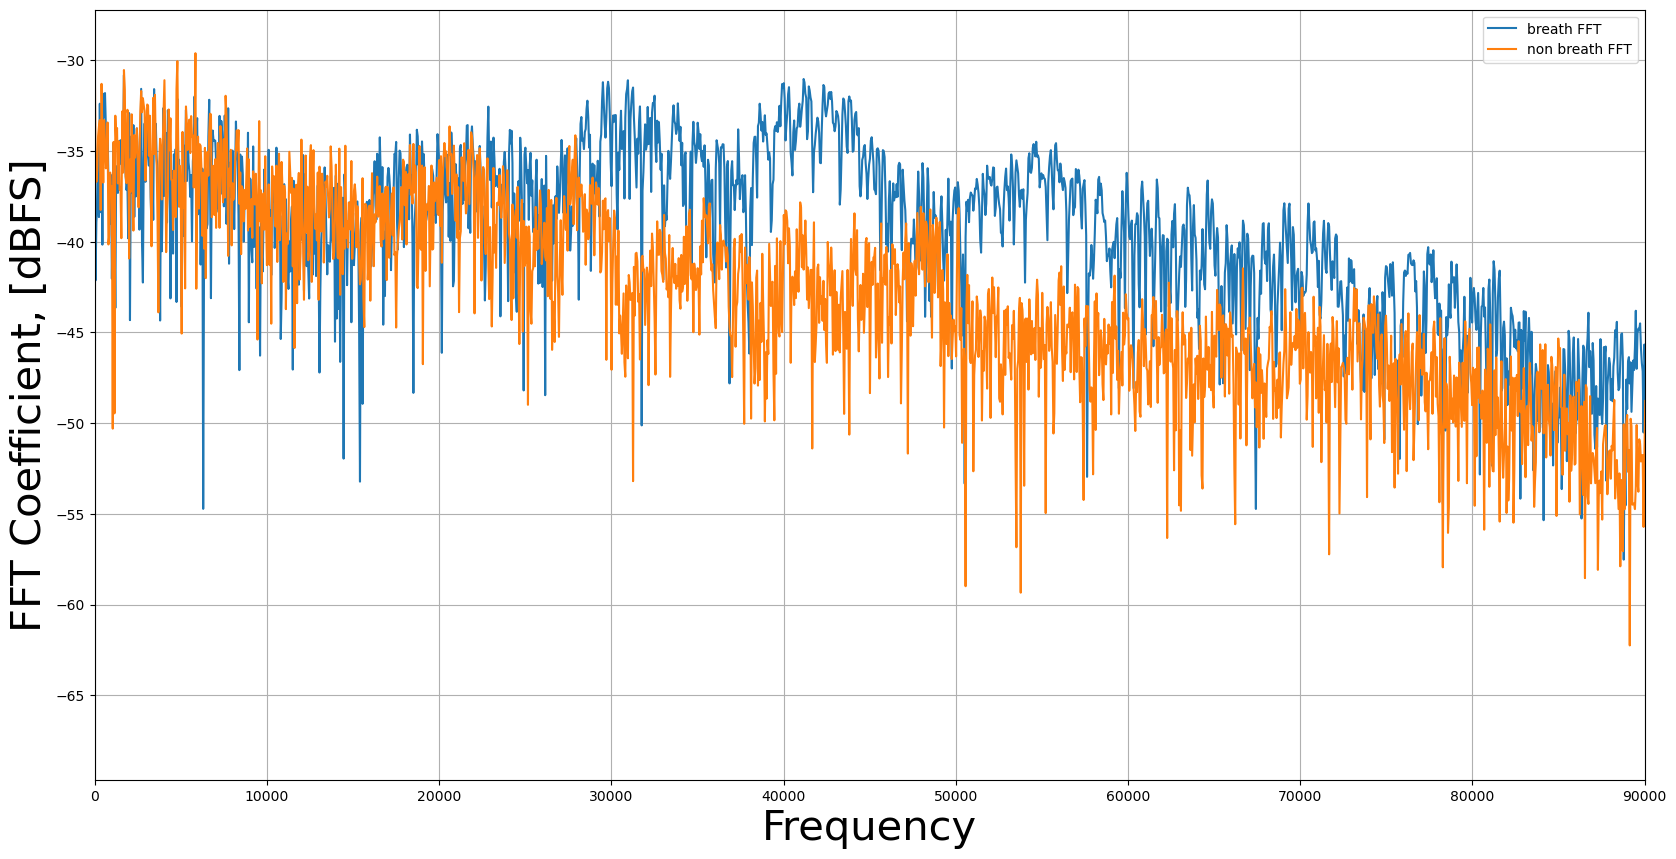

In [285]:
N = len(h1[int(2.2*fs):int(2.22*fs)])
T = 1/fs
yf = scipy.fftpack.fft(h1[int(2.2*fs):int(2.22*fs)])
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

fig, ax = plt.subplots(figsize = (20,10))
ax.plot(xf, 10*np.log10(2.0/N * np.abs(yf[:N//2])), label = 'breath FFT')
plt.xlim(0,90e3)
N = len(h1[int(2.5*fs):int(2.52*fs)])
T = 1/fs
yf = scipy.fftpack.fft(h1[int(2.5*fs):int(2.52*fs)])
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
ax.plot(xf, 10*np.log10(2.0/N * np.abs(yf[:N//2])), label = 'non breath FFT')
plt.legend()
plt.grid()
plt.xlabel('Frequency', fontsize = 30)
plt.ylabel('FFT Coefficient, [dBFS]', fontsize = 30)

In [286]:
#Filter
bpf_l = 25000
bpf_h = 75000
bpf_N = 20
# [bpf_b, bpf_a] = scipy.signal.butter(bpf_N, [bpf_l, bpf_h], btype='bandpass', fs = fs)
# w, h = scipy.signal.freqz(bpf_b, bpf_a)
# plt.semilogx(w*fs/2/np.pi, 20 * np.log10(abs(h)))

bpf_sos = scipy.signal.butter(bpf_N, [bpf_l, bpf_h], btype='bandpass', fs = fs, output='sos')
h1b = scipy.signal.sosfilt(bpf_sos, h1)
h2b = scipy.signal.sosfilt(bpf_sos, h2)
h3b = scipy.signal.sosfilt(bpf_sos, h3)

In [339]:
win_size = 2500
noverlap = np.ceil(win_size/10)

ts_buff = buffer(ts, win_size, noverlap.astype(np.int16))
ts_buff = ts_buff[:,0]

h2_buff = buffer(h2b, win_size, noverlap.astype(np.int16))
h2_buff_pow = 20*np.log10(np.sqrt(np.mean(h2_buff**2,axis=1)))

dB_peak_thresh = 6
pk_distance = 2
h2_peaks, _ = scipy.signal.find_peaks(h2_buff_pow, prominence=dB_peak_thresh, distance=pk_distance)

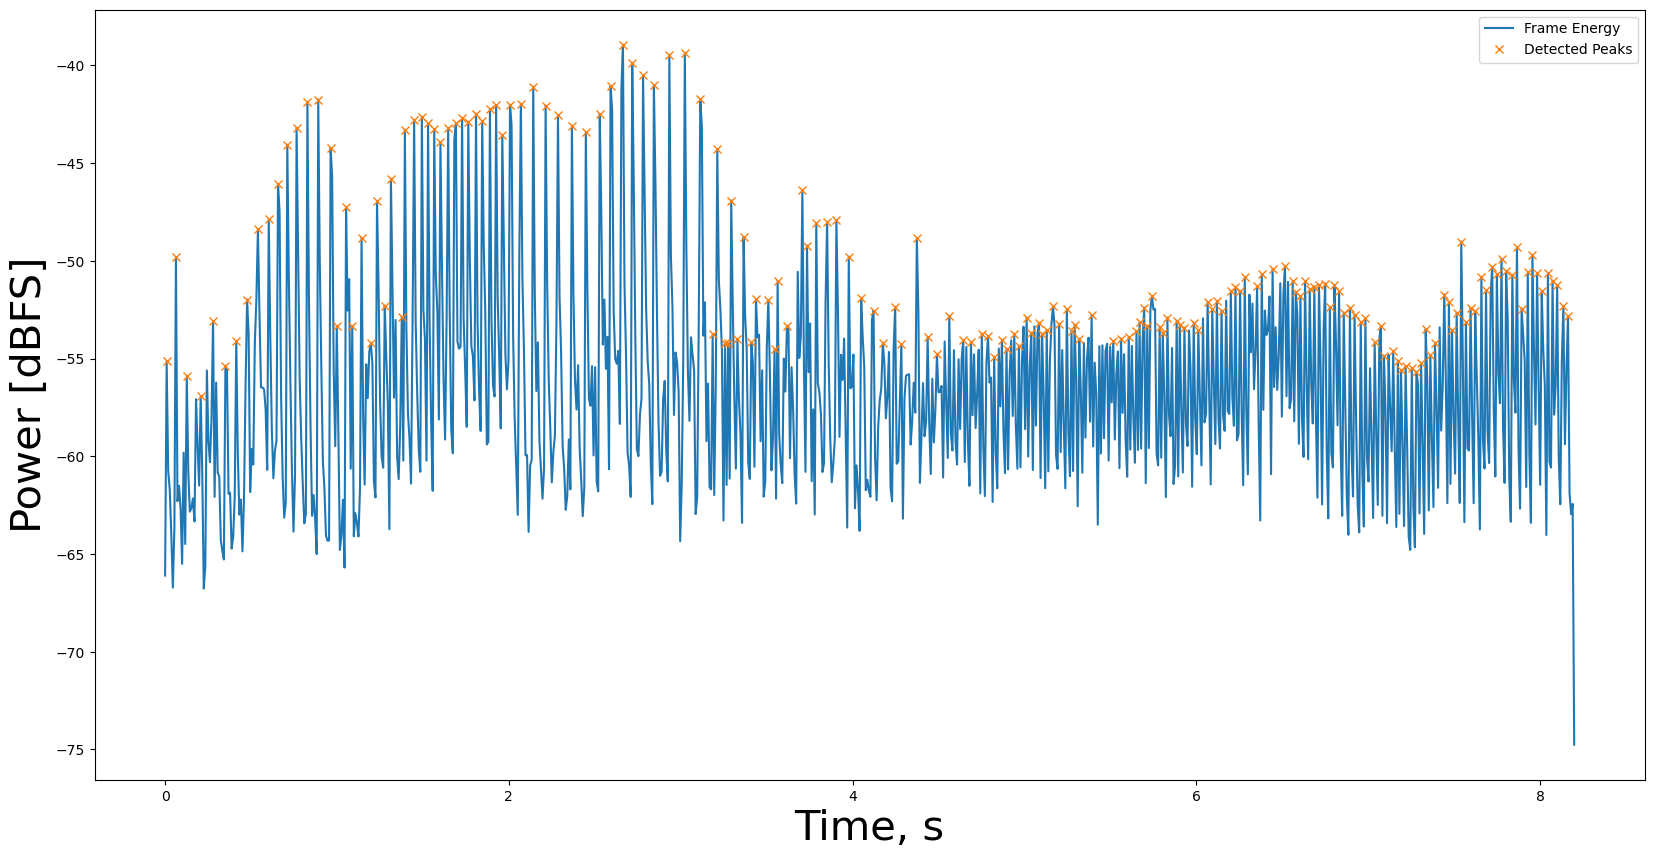

In [340]:
plt.figure()
plt.plot(ts_buff, h2_buff_pow, label='Frame Energy')
plt.plot(ts_buff[h2_peaks], h2_buff_pow[h2_peaks], 'x', label='Detected Peaks')
plt.xlabel('Time, s', fontsize = 30)
plt.ylabel('Power [dBFS]', fontsize = 30)
plt.legend()
# plt.ylim([-30,-10])


In [341]:
click_cutoff = 4.5/(len(h2)/fs)

ts_buff_a = ts_buff[0:np.int16(np.floor(click_cutoff*len(ts_buff)))]
h2_buff_pow_a = h2_buff_pow[0:np.int16(np.floor(click_cutoff*len(h2_buff_pow)))]
h2_clicks_a = h2_buff_pow[h2_peaks[h2_peaks < click_cutoff*len(h2_buff_pow)]]
h2_click_ts_a = ts_buff[h2_peaks[h2_peaks < click_cutoff*len(h2_buff_pow)]]

ts_buff_b = ts_buff[np.int16(np.ceil(click_cutoff*len(ts_buff))):]
h2_buff_pow_b = h2_buff_pow[np.int16(np.ceil(click_cutoff*len(h2_buff_pow))):]
h2_clicks_b = h2_buff_pow[h2_peaks[h2_peaks > click_cutoff*len(h2_buff_pow)]]
h2_click_ts_b = ts_buff[h2_peaks[h2_peaks > click_cutoff*len(h2_buff_pow)]]



Text(0, 0.5, 'Power, dBFS')

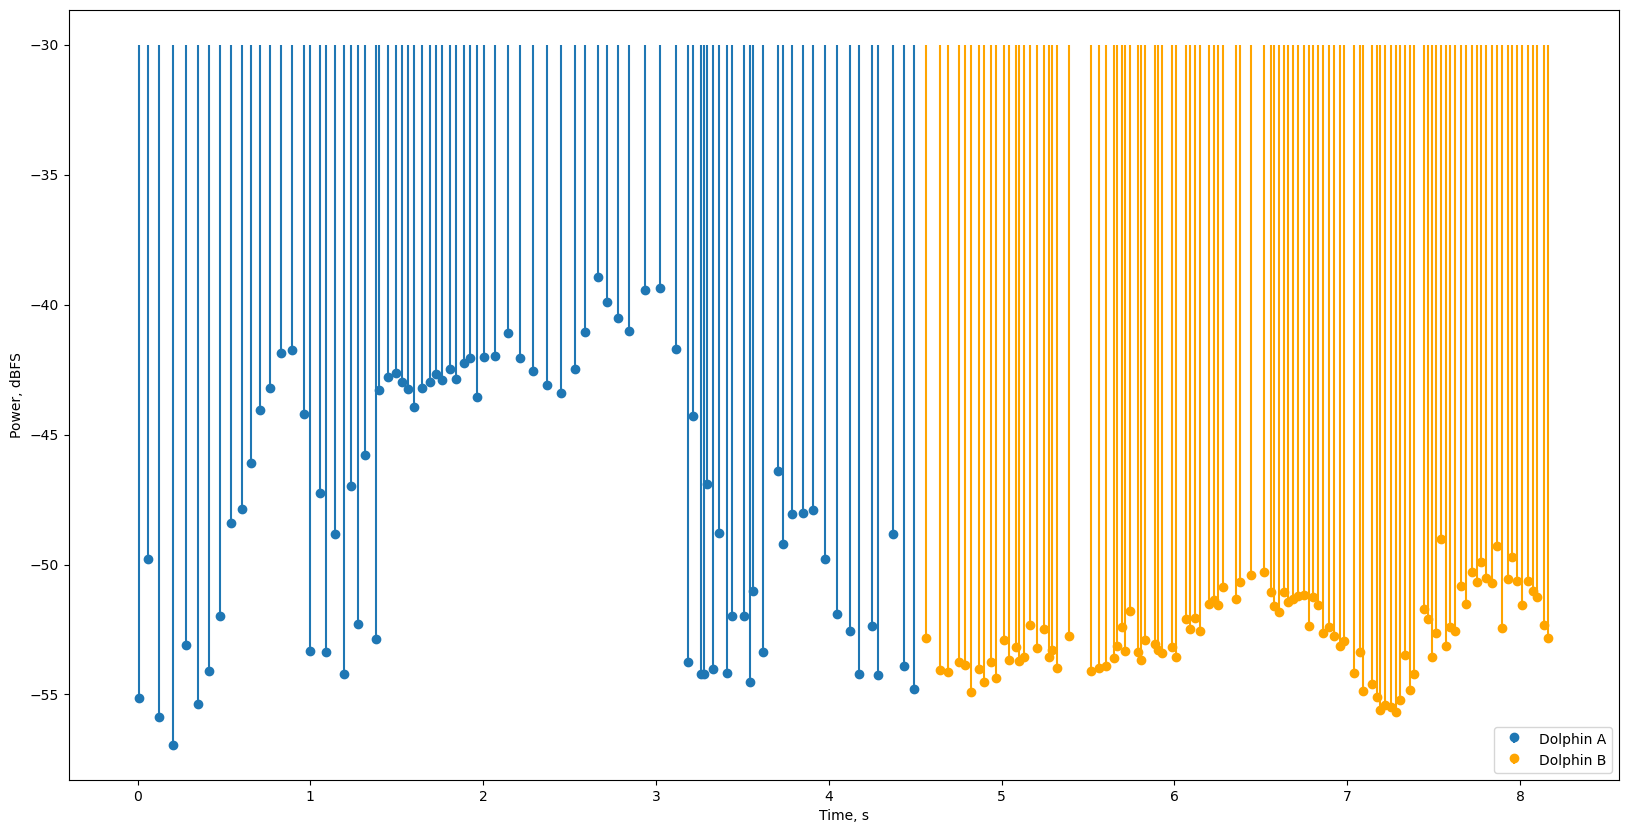

In [342]:
plt.figure()
plt.stem(h2_click_ts_a, h2_clicks_a, bottom=-30, basefmt='None')
plt.stem(h2_click_ts_b, h2_clicks_b, bottom=-30, linefmt='orange', basefmt='None')
plt.legend(['Dolphin A', 'Dolphin B'])
plt.xlabel('Time, s')
plt.ylabel('Power, dBFS')

(83,)


Text(0.5, 1.0, 'Interclick Interval by Click, Total Number of Clicks: A: 82 B: 104\nMean ICI: A: 55.0 B: 35.0\nStd. Dev. ICI: A: 18.0 B: 15.82')

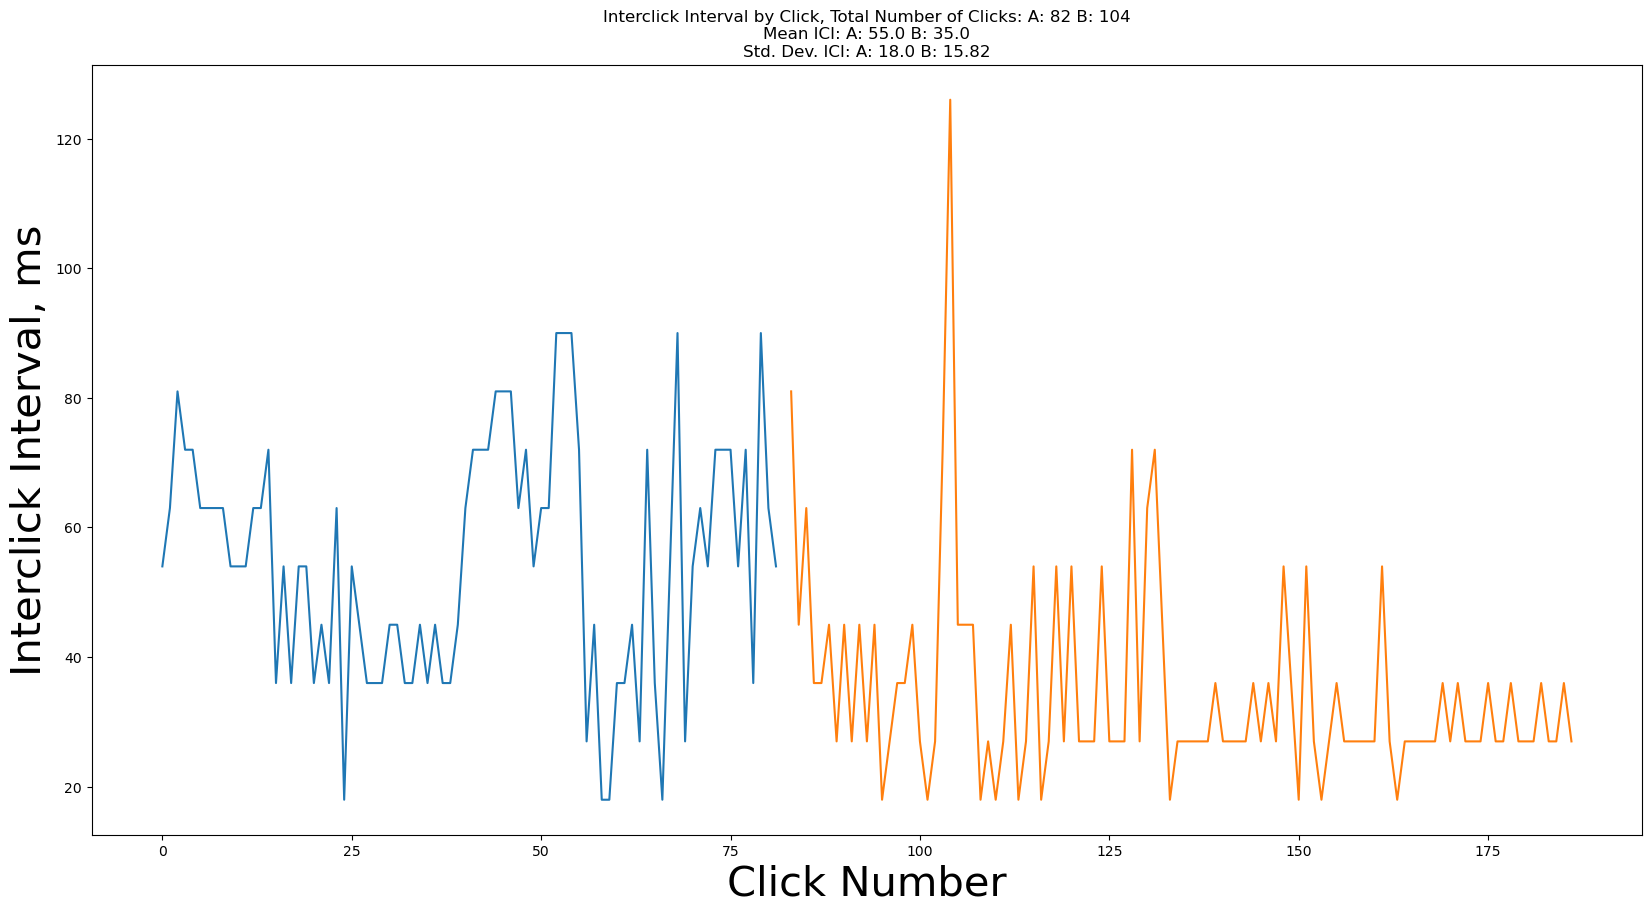

In [343]:
print(h2_click_ts_a.shape)
ici_a = np.diff(h2_click_ts_a)*1000
ici_b = np.diff(h2_click_ts_b)*1000

plt.figure()
plt.plot(np.arange(0,len(ici_a)), ici_a)
plt.plot(np.arange(len(ici_a)+1,len(ici_b)+len(ici_a)+1), ici_b)
plt.ylabel('Interclick Interval, ms', fontsize = 30)
plt.xlabel('Click Number', fontsize = 30)
plt.title('Interclick Interval by Click, Total Number of Clicks: ' + 'A: ' + str(len(ici_a)) + ' B: ' + str(len(ici_b)) + '\n'
          + 'Mean ICI: A: ' + str(np.round(np.mean(ici_a))) + ' B: ' + str(np.round(np.mean(ici_b))) + '\n'
          + 'Std. Dev. ICI: A: ' + str(np.round(np.std(ici_a))) + ' B: ' + str(np.round(np.std(ici_b),2)))

##TASK 2

In [381]:
d = 14  # meters, separating hydrophones
c = 1520  # m/s, speed of sound in water
max_td = d/c

win_size = 5000
noverlap = np.ceil(win_size*.9)

dB_peak_thresh_a = 18
dB_peak_thresh_b = 15
pk_distance = 5
click_cutoff = int(4.5 * fs)

In [382]:
def gccphat(x, y):
    n = (x.shape[0]+y.shape[0])
    max_shift = int(n/2)
    X = np.fft.rfft(x)
    Y = np.fft.rfft(y)
    R = X*np.conj(Y)

    cc = np.fft.irfft(R/np.abs(R))
    cc = np.concatenate((cc[-max_shift:], cc[:max_shift+1]))

    tau = np.argmax(np.abs(cc)) - max_shift

    return tau/fs, cc

def band_energy(fs, y):
    # bandpass regions
    f_l_target = 25000
    f_h_target = 75000

    # FFT size
    n = y.shape[0]

    # FFT frequency bins
    freqs = np.fft.fftfreq(n, 1/fs)
    freqs = freqs[:n//2]

    # FFT output
    Y = np.abs(np.fft.fft(y)) / n
    Y = Y[:n//2]
    Y[1:] = 2*Y[1:]

    f_l = np.argmin(np.abs(freqs-f_l_target))
    f_h = np.argmin(np.abs(freqs-f_h_target))

    # energy = 10*np.log10(np.sum(np.abs(Y[f_l:f_h]**2)))
    energy = 10*np.log10(np.mean(np.abs(Y)**2) * fs)

    print(energy)

    return energy


In [386]:
# Dolphin A
h1_a = h1[:click_cutoff]
h2_a = h2[:click_cutoff]
h3_a = h3[:click_cutoff]

# Segment/buffer signals
h1_buff = buffer(h1_a, win_size, noverlap.astype(np.int16))
h2_buff = buffer(h2_a, win_size, noverlap.astype(np.int16))
h3_buff = buffer(h3_a, win_size, noverlap.astype(np.int16))

h1_powers = []
h2_powers = []
h3_powers = []

delays_12 = []
delays_13 = []
delays_23 = []

good_frame_delays_12 = []
good_frame_delays_13 = []
good_frame_delays_23 = []

dBThresh = -46

for i, (b1, b2, b3) in enumerate(zip(h1_buff, h2_buff, h3_buff)):
    h1_powers.append(20*np.log10(np.sqrt(np.mean(b1**2))))
    h2_powers.append(20*np.log10(np.sqrt(np.mean(b2**2))))
    h3_powers.append(20*np.log10(np.sqrt(np.mean(b3**2))))

    lag_12, cc_12 = gccphat(b1, b2)
    lag_13, cc_13 = gccphat(b1, b3)
    lag_23, cc_23 = gccphat(b2, b3)

    delays_12.append(lag_12)
    delays_13.append(lag_13)
    delays_23.append(lag_23)

    b12 = (b1+b2)/2
    b13 = (b1+b3)/2
    b23 = (b2+b3)/2

    e12 = 10*np.log10(np.mean(np.abs(b12**2)))
    e13 = 10*np.log10(np.mean(np.abs(b13**2)))
    e23 = 10*np.log10(np.mean(np.abs(b23**2)))

    if e12 > dBThresh:
        good_frame_delays_12.append(lag_12)
    else:
        good_frame_delays_12.append(np.nan)

    if e13 > dBThresh:
        good_frame_delays_13.append(lag_13)
    else:
        good_frame_delays_13.append(np.nan)

    if e23 > dBThresh:
        good_frame_delays_23.append(lag_23)
    else:
        good_frame_delays_23.append(np.nan)


C:\Users\BenjaminPierceMaster\AppData\Local\Temp\ipykernel_2668\2324663614.py:8: RuntimeWarning: invalid value encountered in divide
  cc = np.fft.irfft(R/np.abs(R))


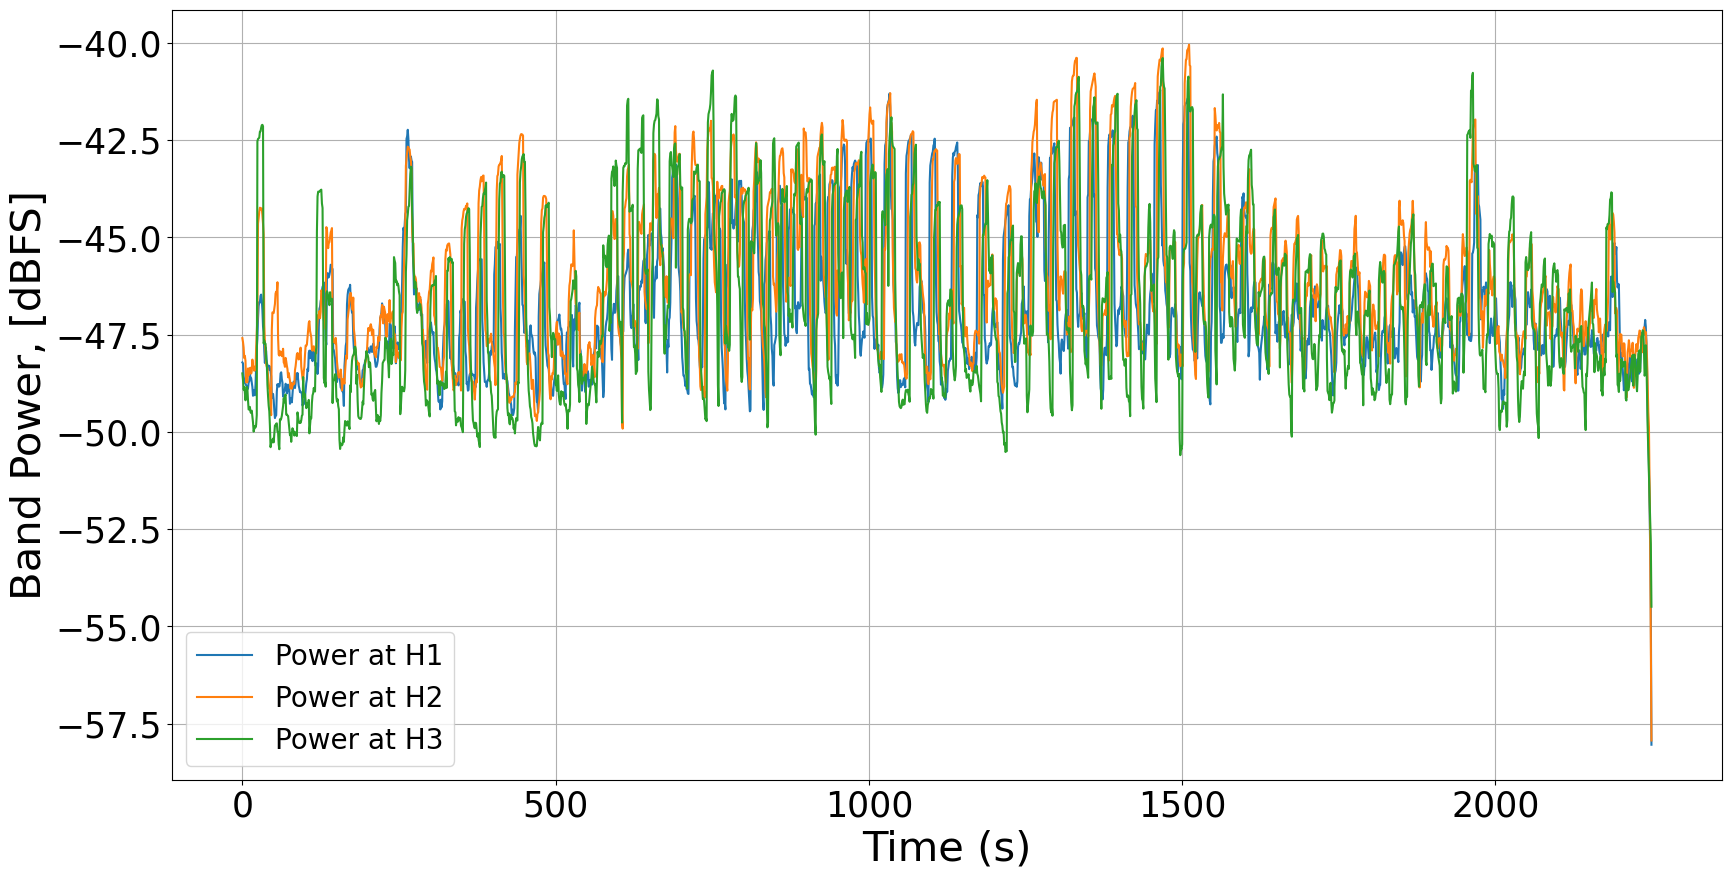

In [387]:
plt.figure()
xs = np.arange(0,len(h1_powers))
time = win_size/fs

plt.plot(xs,(h1_powers), label = 'Power at H1')
plt.plot(xs,(h2_powers), label = 'Power at H2')
plt.plot(xs,(h3_powers), label = 'Power at H3')

plt.legend(fontsize = 20)
plt.xlabel('Time (s)', fontsize = 30)
plt.ylabel('Band Power, [dBFS]', fontsize = 30)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.grid()
# plt.xlim([300,500])


[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

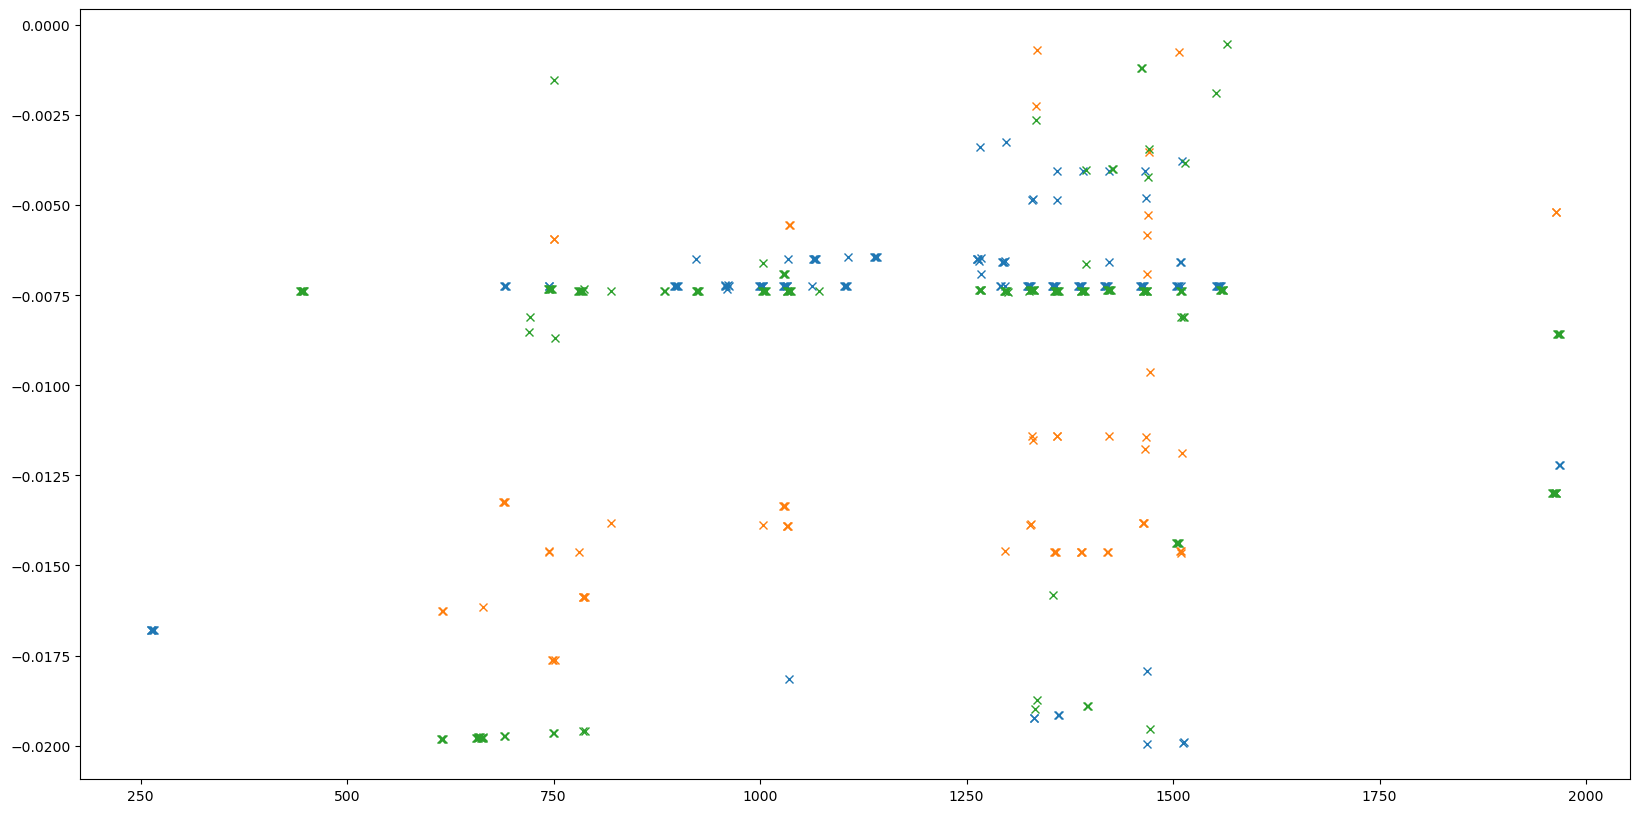

In [388]:
print(good_frame_delays_12)
plt.figure()
plt.plot(good_frame_delays_12, 'x')
plt.plot(good_frame_delays_13, 'x')
plt.plot(good_frame_delays_23, 'x')